In [1]:
%matplotlib inline

In [2]:
import random
import time
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gensim.models import KeyedVectors
from tqdm import tqdm

# Performance comparison
This notebook compares the performance between three approaches to store and retrieve word embeddings:
1. Read in whole binary file
2. Store and read from Mongo DB
3. Store and read from SQLite DB

Import classes from `database.py` to read from SQLite and Mongo DB.`

In [3]:
from database import WordEmbeddingSQLiteDB, WordEmbeddingMongoDB

## 1 Configuration
Read configurations for accessing databases and binary data file.

In [4]:
with open('db.yaml') as f:
    conf = yaml.safe_load(f)

In [5]:
HOST = conf['mongodb']['host']
PORT = conf['mongodb']['port']
DB_NAME = conf['name']
TABLE_NAME = conf['data']['google_news_vec']['name']
DATA_PATH = conf['data']['google_news_vec']['path']

## 2 Read data
For each database option [1, 10, 100, 1000, 10000, 100000] number of records will be read into the format {'word': ndarray}. To get a somewhat more stable estimate of time the records will be read five times. I.e. 1 record will be read in five times, 10 records will be read in five times and so on. The final time estimate will then be the average time for all five iterations.

In [6]:
random.seed(1)

In [7]:
n = [1*10**i for i in range(6)]

In [8]:
t_embed = []
t_inmemory = []
t_db = []
t_sql = []
word_lst = []
embed = KeyedVectors.load_word2vec_format(DATA_PATH, binary=True)
for i in n:
    word_lst.append(random.choices(list(embed.vocab.keys()), k=i))

### 2.1 Retrive word vectors in memory
This approach is fast since it reads in the whole binary file into memory and then ectract the word embeddings in memory. However, this assumes that the whole binary file fits in memory and the approach is therefore not possible for large files. However, it still provides some value to this comparison as a fast benchmark. 

In [9]:
for words in tqdm(word_lst):
    lst = []
    for i in range(5):
        start = time.time()
        _ = {w: embed[w] for w in words}
        lst.append(time.time() - start)
    t_inmemory.append(sum(lst) / len(lst))

100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


In [10]:
del embed #to free up memory

### 2.2 Read binary and then retrieve the word vectors
Read in the binary file into memory and then retrieve the embeddings.

In [11]:
for words in tqdm(word_lst):
    lst = []
    for i in range(5):
        start = time.time()
        embed = KeyedVectors.load_word2vec_format(DATA_PATH, binary=True)
        _ = [embed[w] for w in words]
        lst.append(time.time() - start)
        del embed # to free up memory
    t_embed.append(sum(lst) / len(lst))

100%|██████████| 6/6 [13:06<00:00, 131.08s/it]


### 2.3 SQLite DB
Read the embeddings from a SQLite DB. For details how this database was created please refer to `database.py` and ... `word`is set as an index in the table.

In [12]:
for words in tqdm(word_lst):
    lst = []
    for i in range(5):
        start = time.time()
        with WordEmbeddingSQLiteDB(f"{conf['sqlite']['path']}/{DB_NAME}.db") as db:
            _ = db.read_embeddings(words, TABLE_NAME)
        lst.append(time.time() - start)
    t_sql.append(sum(lst) / len(lst))

100%|██████████| 6/6 [07:39<00:00, 76.60s/it] 


### 2.4 Mongo DB
Read the embeddnings from a Mongo DB. For details how this database were created please refer to `database.py` and ... `word` is set as an index in the collection.

In [13]:
for words in tqdm(word_lst):
    lst = []
    for i in range(5):
        start = time.time()
        with WordEmbeddingMongoDB(DB_NAME, HOST, PORT) as db:
            _ = db.read_embeddings(words, TABLE_NAME)
        lst.append(time.time() - start)
    t_db.append(sum(lst) / len(lst))

100%|██████████| 6/6 [03:39<00:00, 36.63s/it]


## 3 Results

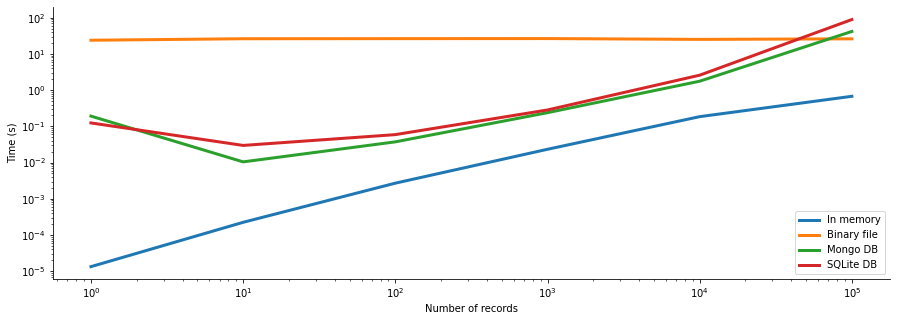

In [14]:
para = {'linewidth': 3}

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(n, t_inmemory, label='In memory', **para)
ax.plot(n, t_embed, label='Binary file', **para)
ax.plot(n, t_db, label='Mongo DB', **para)
ax.plot(n, t_sql, label='SQLite DB', **para)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Time (s)')
ax.set_xlabel('Number of records')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

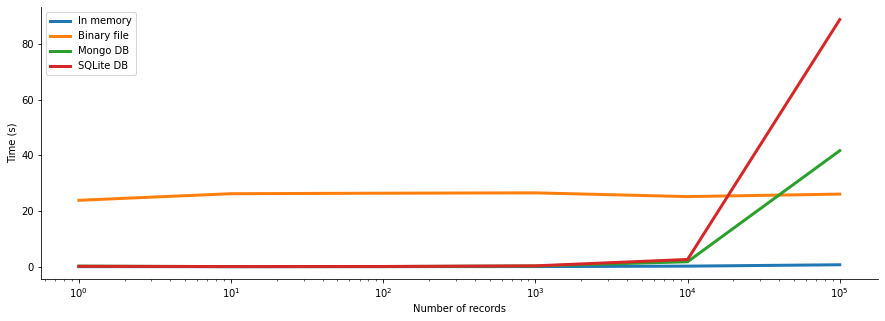

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(n, t_inmemory, label='In memory', **para)
ax.plot(n, t_embed, label='Binary file', **para)
ax.plot(n, t_db, label='Mongo DB', **para)
ax.plot(n, t_sql, label='SQLite DB', **para)

ax.set_xscale('log')
ax.set_ylabel('Time (s)')
ax.set_xlabel('Number of records')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()